In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rtree import index
import xgboost as xgb
import math

In [4]:
mc_data = pd.read_json('../../datasets/SciFi_200000_Bool_TrackStudy.json')
%store mc_data

Stored 'mc_data' (DataFrame)


In [3]:
%store -r mc_data

In [4]:
###### Data columns
i = 0
for val in mc_data.columns:
    print(i," ",val)
    i = i + 1

0   MCParticleID
1   MC_Hit_X
2   MC_Hit_Y
3   MC_Hit_Z
4   PrHit_LHCbID
5   PrHit_Xat0
6   PrHit_Zat0
7   PrHit_isX
8   PrHit_planeCode
9   PrHit_w2
10   PrHit_yMax
11   PrHit_yMin
12   PrHit_zone
13   event


In [6]:
mc_hits = mc_data.values

In [7]:
zLays = [7825.99951172, 7895.99951172, 7966.        , 8036.00048828,
       8507.99902344, 8577.99902344, 8647.99902344, 8718.00097656,
       9192.99902344, 9262.99902344, 9332.99902344, 9403.00097656]

max_x = 3182.8356933594
min_x = -3182.8576660156
min_y = -2438.6506347656
max_y = 2438.6506347656

In [8]:
events = np.unique(mc_hits[:,13])
print(events)

[15837 15838 15839 15840 15841 15842 15843 15844 15845 15846 15847 15848
 15849 15850 15851 15852 15853 15854 15855 15856 15857 15858 15859 15860
 15861 15862 15863 15864 15865 15866 15867 15868 15869 15870 15871 15872
 15873 15874 15875 15876 15877 15878 15879 15880 15881 15882 15883 15884
 15885 15886 15887 15888 15889 15890 15891 15892 15893 15894 15895 15896
 15897 15898 15899 15900 15901 15902 15903 15904 15905 15906 15907 15908
 15909 15910 15911 15912 15913 15914 15915 15916 15917 15918 15919 15920
 15921 15922 15923 15924 15925 15926 15927 15928 15929 15930 15931 15932
 15933 15934 15935 15936 15937 15938 15939 15940 15941 17909 17910 17911
 17912 17913 17914 17915 17916 17917 17918 17919 17920 17921 17922 17923
 17924 17925 17926 17927 17928 17929 17930 17931 17932 17933 17934 17935
 17936 17937 17938 17939 17940 17941 17942 17943 17944 17945 17946 17947
 17948 17949 17950 17951 17952 17953 17954 17955 17956 17957 17958 17959
 17960 17961 17962 17963 17964 17965 17966 17967 17

In [9]:
%store zLays
%store max_x
%store min_x
%store max_y
%store min_y
%store events

Stored 'zLays' (list)
Stored 'max_x' (float)
Stored 'min_x' (float)
Stored 'max_y' (float)
Stored 'min_y' (float)
Stored 'events' (ndarray)


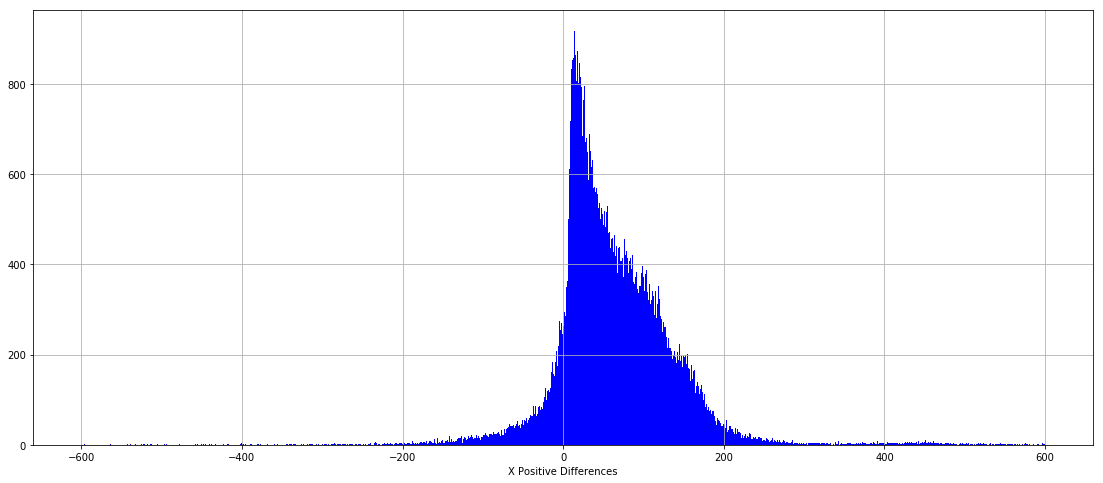

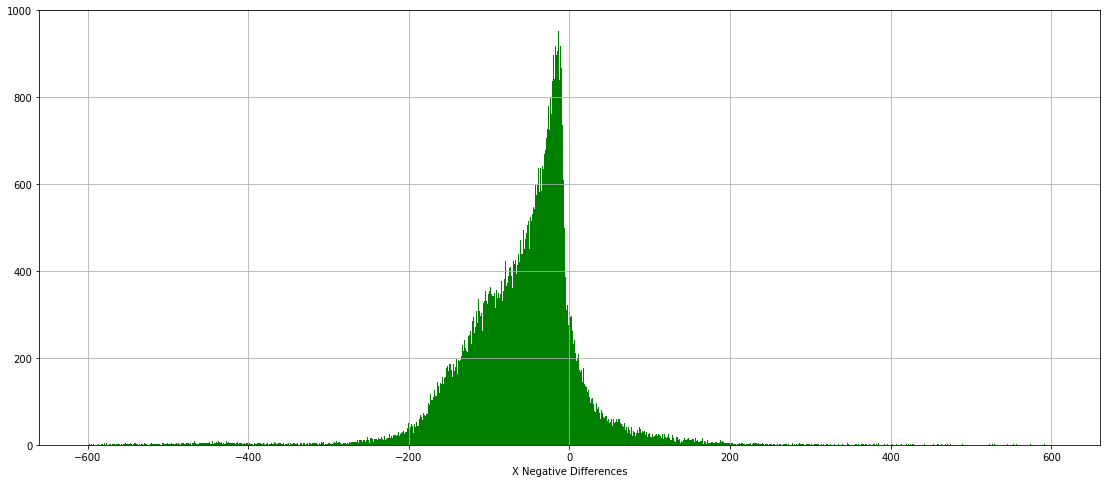

In [8]:

X_plot_positive = []
X_plot_negative = []

for hit in mc_hits:
    
    if (len(hit[5]) > 1):
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[3] == 0):
            continue
        if X_final[0] > 0:
            X_plot_positive.append(X_final[3] - X_final[0])
        else:
            X_plot_negative.append(X_final[3] - X_final[0])

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_positive, 1000, facecolor='blue', range=(-600,600))
ax.set_xlabel('X Positive Differences')
ax.grid()
plt.show()

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_negative, 1000, facecolor='green', range=(-600,600))
ax.set_xlabel('X Negative Differences')
ax.grid()
plt.show()

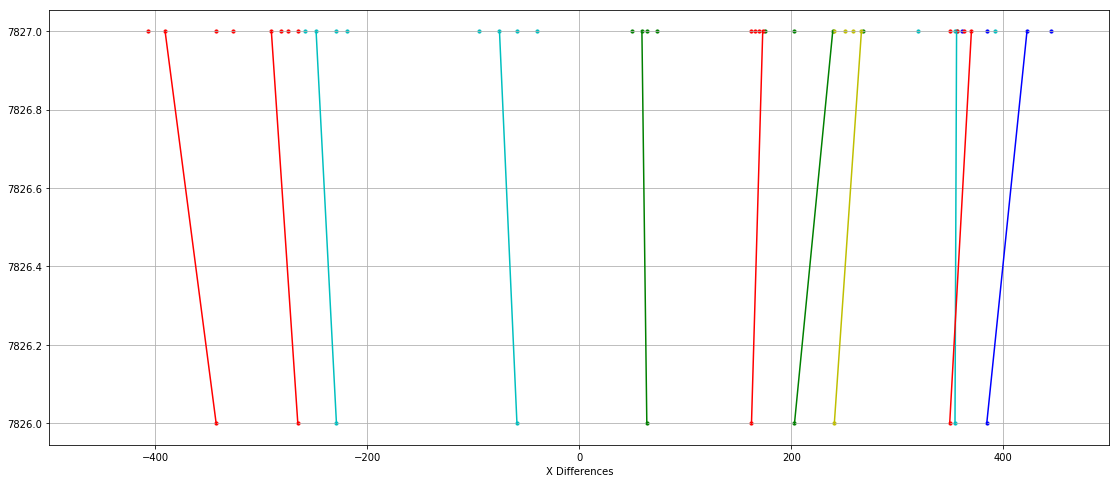

In [9]:

import itertools
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)

X_plot = []
Y_plot = []
color = 0.0

colors = itertools.cycle(["r", "b", "g", "y", "c"])

for hit in mc_hits[mc_hits[:,13] == 15862][:30]:
    
    if (len(hit[5]) > 1):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        if (X_final[1] == 0) or (X_final[2] == 0) or (X_final[3] == 0) or (X_final[4] == 0):
            continue
            
        actual = next(colors)
        ax.scatter([X_final[0], X_final[0], X_final[1],X_final[2],X_final[3]],[zLays[0], zLays[0]+1,zLays[0]+1, zLays[0]+1, zLays[0]+1], s=10, c=actual)
        ax.plot([X_final[0], X_final[3]],[zLays[0],zLays[0]+1], c=actual)
        
ax.set_xlim(-500, 500)
ax.set_xlabel('X Differences')
ax.grid()
plt.show()

In [42]:
print(mpmath.acot(16.43))

0.0607892828646912


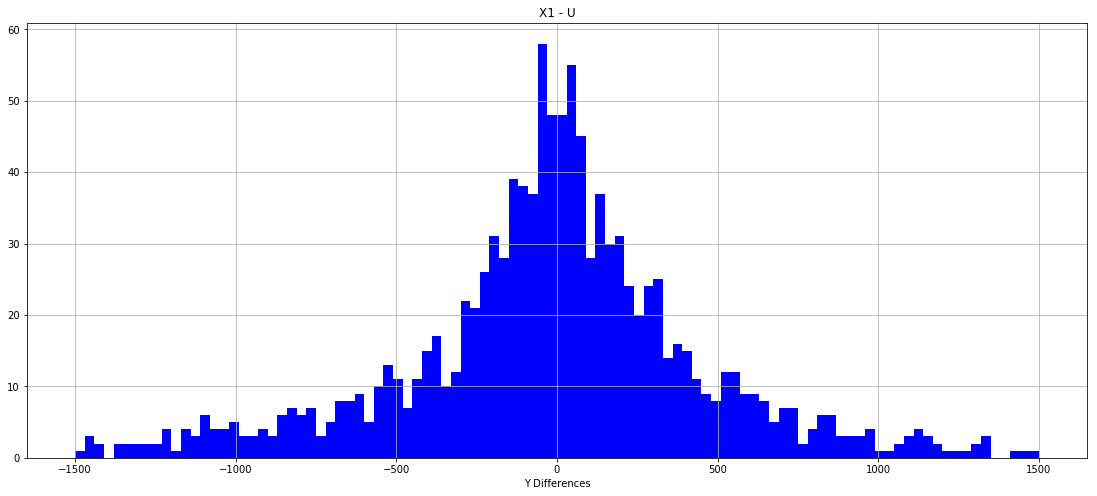

Mean -11.304472 
Variance 531.003003 


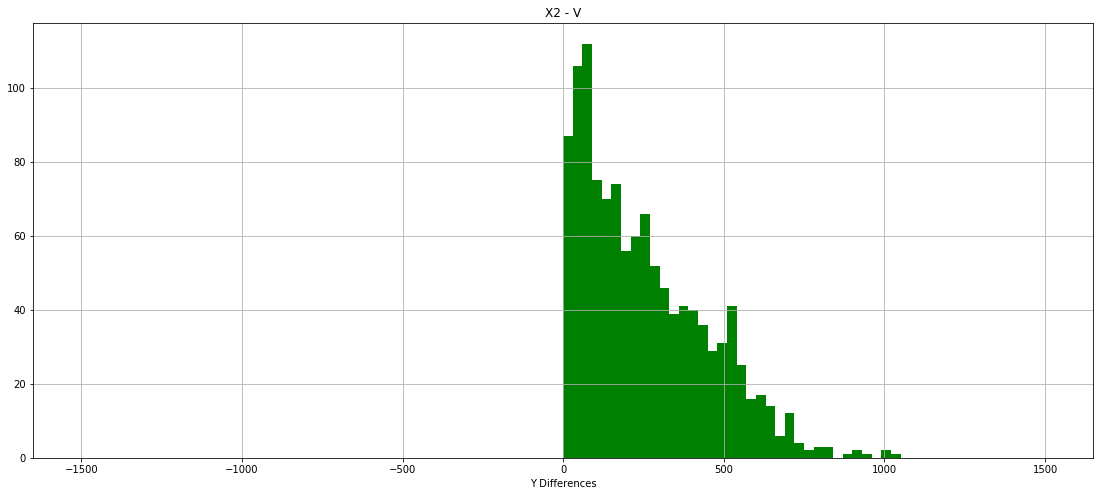

Mean 253.465348 
Variance 195.679683 


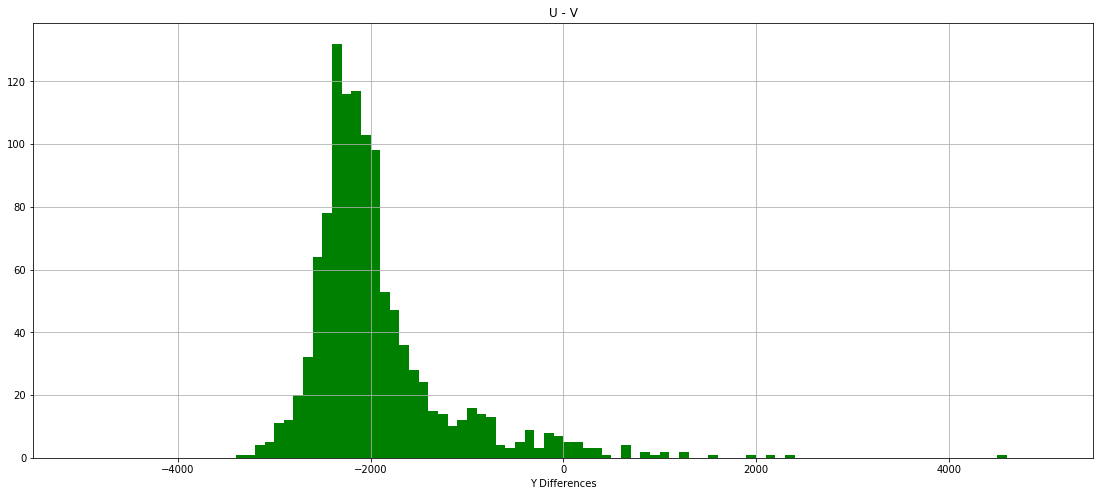

Mean -1643.017318 
Variance 2343.381940 


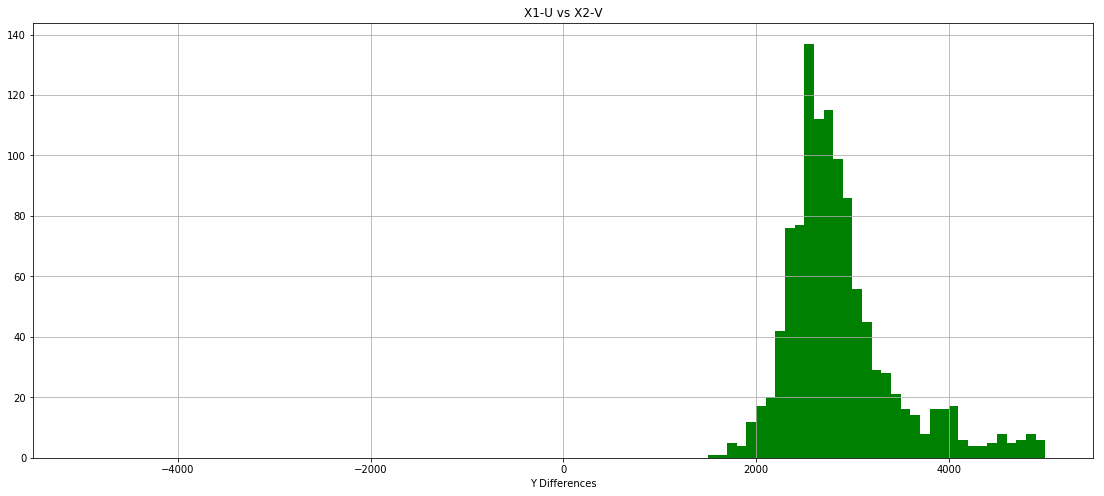

Mean 3234.283951 
Variance 2343.381940 


In [13]:
X_plot_X1_U = []
X_plot_X2_V = []
X_plot_U_V = []
unified_plot = []
pos = 0
event_hits = mc_hits[mc_hits[:,13] < events[10]]
acot = 11.4300526450039

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[0] == 0) or len(hit[1]) < 12:
            continue
        
        X_plot_X1_U.append(hit[2][0])
        X_plot_X2_V.append(np.abs(hit[1][0] - hit[1][1]) * acot)
        X_plot_U_V.append( hit[2][0] - (max_y - np.abs(X_final[0] - X_final[1]) * acot))
        unified_plot.append( hit[2][0] - (min_y - np.abs(X_final[0] - X_final[1])*acot))
        
        pos += 1
        
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_X1_U, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('Y Differences')
ax.set_title('X1 - U')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_X1_U)))
print("Variance %f " % np.std(np.array(X_plot_X1_U)))

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_X2_V, 100, facecolor='green', range=(-1500,1500))
ax.set_xlabel('Y Differences')
ax.set_title('X2 - V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_X2_V)))
print("Variance %f " % np.std(np.array(X_plot_X2_V)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot_U_V, 100, facecolor='green',range=(-5000,5000))
ax.set_xlabel('Y Differences')
ax.set_title('U - V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot_U_V)))
print("Variance %f " % np.std(np.array(X_plot_U_V)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(unified_plot, 100, facecolor='green',range=(-5000,5000))
ax.set_xlabel('Y Differences')
ax.set_title('X1-U vs X2-V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(unified_plot)))
print("Variance %f " % np.std(np.array(unified_plot)))

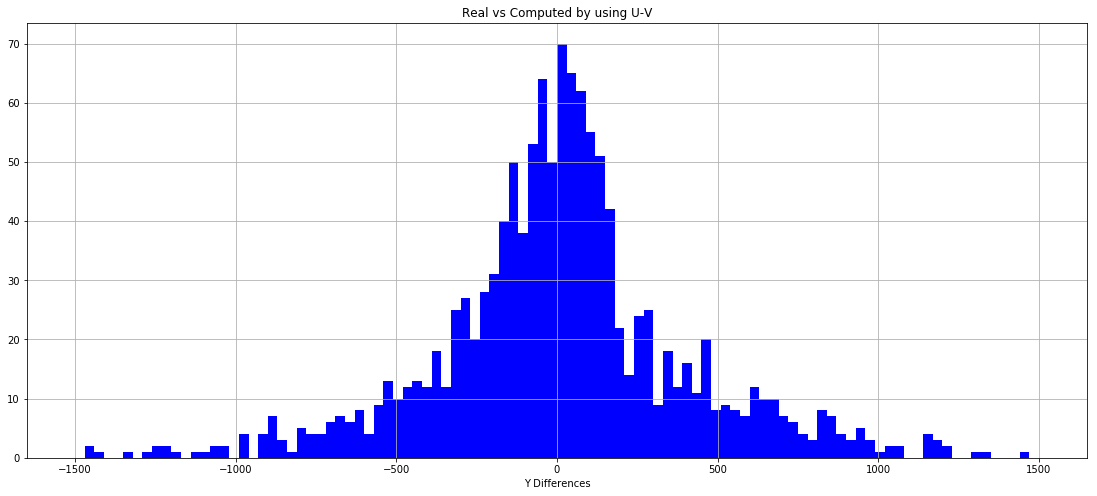

Mean 4.305331 
Variance 439.215649 


In [12]:
X_plot = []
pos = 0

event_hits = mc_hits[mc_hits[:,13] < events[10]]

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[1] == 0):
            continue
        
        calc = ( 0.5 * (X_final[2] - X_final[1]) * mpmath.acot(0.05))
        X_plot.append(calc - hit[2][1])
        
        pos += 1
        
fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X_plot, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('Y Differences')
ax.set_title('Real vs Computed by using U-V')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X_plot)))
print("Variance %f " % np.std(np.array(X_plot)))

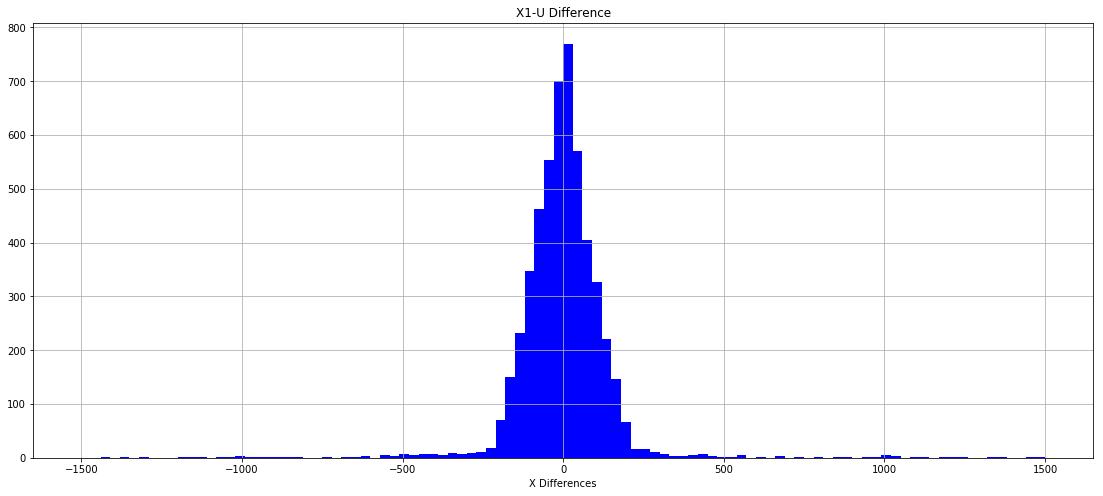

Mean 2.286665 
Variance 201.420861 


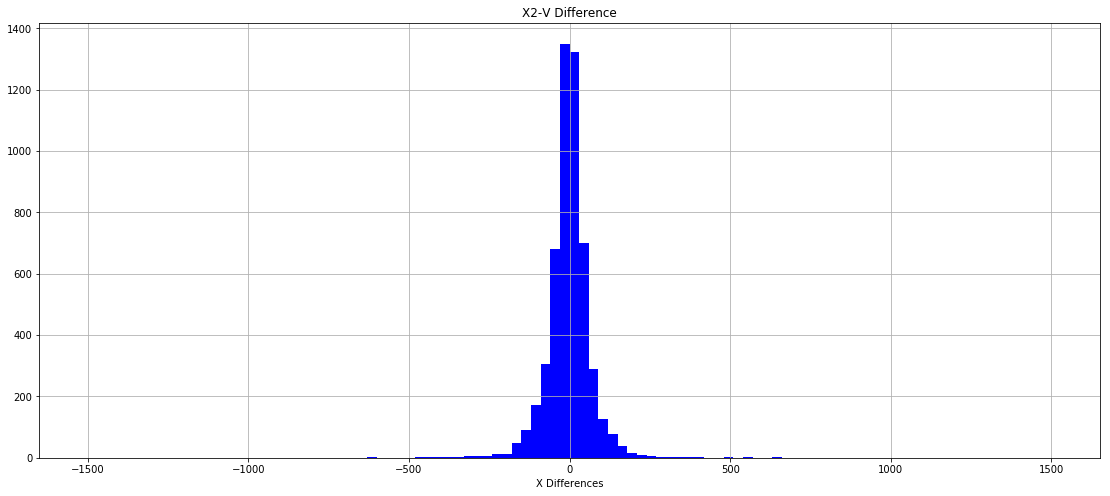

Mean -1.554239 
Variance 82.585660 


In [9]:
UV_diff = []
X1U_diff = []
X2V_diff = []

pos = 0

event_hits = mc_hits[mc_hits[:,13] < events[40]]

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
                
        if (X_final[1] != 0) and (X_final[1] != 0):
            X1U_diff.append(X_final[0] - X_final[3])
        if (X_final[2] != 0) and (X_final[3] != 0):
            X2V_diff.append(X_final[2] - X_final[3])
        if (X_final[1] != 0) and (X_final[2] != 0):
            UV_diff.append(X_final[1] - X_final[2])
    

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X1U_diff, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('X Differences')
ax.set_title('X1-U Difference')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X1U_diff)))
print("Variance %f " % np.std(np.array(X1U_diff)))


fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(X2V_diff, 100, facecolor='blue', range=(-1500,1500))
ax.set_xlabel('X Differences')
ax.set_title('X2-V Difference')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(X2V_diff)))
print("Variance %f " % np.std(np.array(X2V_diff)))

In [48]:
max_y

2438.6506347656

X1: 1313.6906738281
U: 1356.0277099609
V: 1398.7213134766
X2: 1441.6459960938
U y: 35.3050384521
X2 y: 35.9096641541
Z: [7826.125, 7896.126953125, 7966.1284179688, 8036.1298828125]
2425.3623046875
1.3780976534
3.1807861327999944
Pred 36.44938308712339
X1-U: 483.9145373418008
U-V: 243.99506058890347
V-X2: 490.6313673940267


X1: 210.9742736816
U: 229.5440216064
V: 249.2725067139
X2: 270.9136047363
U y: -32.0785980225
X2 y: -38.6596260071
Z: [7825.8930664062, 7895.8842773438, 7965.875, 8035.861328125]
-0.6218893528
-2424.6062011719
-2.6385192871999834
Pred -30.235351640719212
X1-U: 212.25319002955789
U-V: 112.74880831648649
V-X2: 247.35888228521708


X1: -265.0711669922
U: -303.9426269531
V: -347.2135925293
X2: -394.6297912598
U y: 18.4350509644
X2 y: 18.8089694977
Z: [7826.0634765625, 7896.0659179688, 7966.06640625, 8036.068359375]
2425.3623046875
1.3780976534
1.294860839900025
Pred 14.838029702561116
X1-U: -444.3028204377802
U-V: -247.29469986347587
V-X2: -541.9696314877411


X1: 86.71

X1: 794.9123535156
U: 808.6896972656
V: 822.5645141602
X2: 836.5862426758
U y: 142.6450042725
X2 y: 145.1535797119
Z: [7826.5083007812, 7896.4233398438, 7966.5185546875, 8036.5234375]
2425.3623046875
1.3780976534
12.53607177729998
Pred 143.66865218171492
X1-U: 157.47575965562208
U-V: 79.29494139825754
V-X2: 160.26909030842805


X1: -346.7247009277
U: -355.8914794922
V: -365.4873657227
X2: -375.5601806641
U y: 121.6913146973
X2 y: 120.2859725952
Z: [7826.4399414062, 7896.4379882812, 7966.4360351562, 8036.43359375]
2425.3623046875
1.3780976534
10.604125976600017
Pred 121.52392652212124
X1-U: -104.77675844006679
U-V: -54.840740752981276
V-X2: -115.1328016162379


X1: 902.9507446289
U: 926.4014282227
V: 926.6209106445
X2: 950.2196044922
U y: 57.5517196655
X2 y: 58.1274528503
Z: [7826.2045898438, 7895.8125, 7896.4624023438, 7966.2094726562]
2425.3623046875
1.3780976534
4.8455810547000056
Pred 55.527184055363335
X1-U: 268.0425400126416
U-V: 1.2543477803551728
V-X2: 269.73430495606357


X1: -

X1: -357.5747375488
U: -375.919342041
V: -394.3730773926
X2: -412.9607849121
U y: 213.1290130615
X2 y: 216.6371917725
Z: [7826.7602539062, 7896.7670898438, 7966.7739257812, 8036.7807617188]
2425.3623046875
1.3780976534
18.65307617190001
Pred 213.80073564311485
X1-U: -209.67978881931674
U-V: -105.46358012505209
V-X2: -212.45846913631516


X1: 152.7353820801
U: 154.0765991211
V: 155.4082336426
X2: 156.7331848145
U y: -38.2315368652
X2 y: -38.7780151367
Z: [7825.8627929688, 7895.8623046875, 7965.8618164062, 8035.8608398438]
-0.6218893528
-2424.6062011719
-3.1707916260000104
Pred -36.33485204268569
X1-U: 15.330180927984726
U-V: 7.610326114453827
V-X2: 15.144261193421737


X1: 1174.8973388672
U: 1203.1519775391
V: 1231.5390625
X2: 1260.09375
U y: -59.3099517822
X2 y: -60.3350906372
Z: [7825.7875976562, 7895.7861328125, 7965.7846679688, 8035.783203125]
-0.6218893528
-2424.6062011719
-5.1248779297000056
Pred -58.72785806393786
X1-U: 322.9519978154404
U-V: 162.23293291300837
V-X2: 326.38157161

X1: 1539.4602050781
U: 1586.4219970703
V: 1633.7727050781
X2: 1681.5092773438
U y: 421.2310791016
X2 y: 438.8139953613
Z: [7827.484375, 7897.5166015625, 7967.548828125, 8037.5810546875]
2425.3623046875
1.3780976534
36.87658691410002
Pred 422.97845725474866
X1-U: 536.7757387022449
U-V: 270.61053455096715
V-X2: 545.6315177514979


X1: 1826.16015625
U: 1879.5493164062
V: 1933.3161621094
X2: 1987.3717041016
U y: -1054.2156982422
X2 y: -1087.1652832031
Z: [7822.2626953125, 7892.2036132812, 7962.14453125, 8032.0859375]
-0.6218893528
-2424.6062011719
-92.5340576172
Pred -1066.782734531768
X1-U: 610.2408929858677
U-V: 307.27892927103767
V-X2: 617.8576722249582




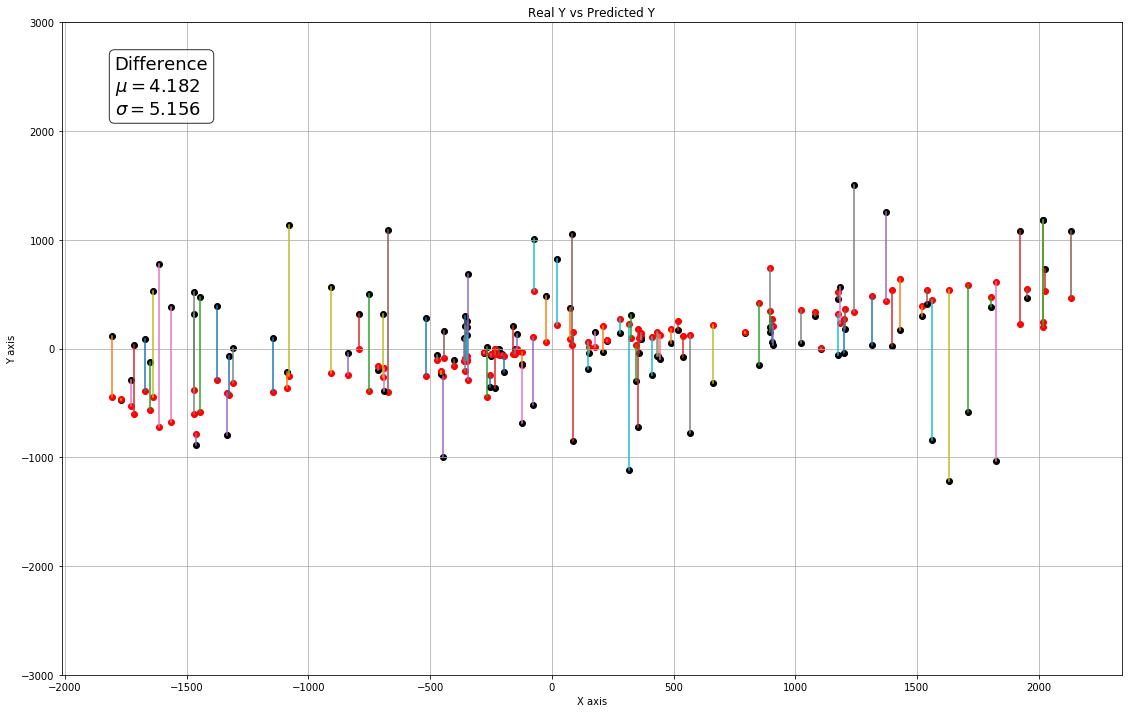

Mean Real 93.746988 
Variance Real 509.336913 
Mean Predicted 18.100673 
Variance Predicted 334.246234 


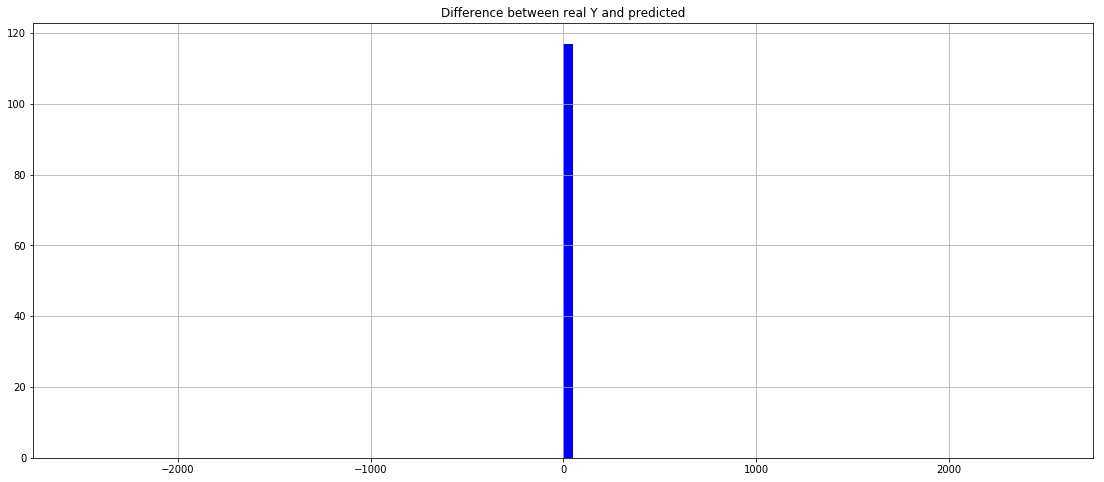

Mean 4.181591 
Variance 5.155778 


In [97]:
Real_Y = []
Pr_Y = []
diff = []

pos = 0
tan = 1 / math.tan(math.radians(5))

event_hits = mc_hits[mc_hits[:,13] < events[1]]

fig = plt.figure(figsize=(19, 12))
ax = fig.add_subplot(111)

for hit in event_hits:
    
    if (len(hit[5]) > 0):
        
        X_final = np.zeros(12)
        
        actual = -1
        for i in range(0, len(hit[5])):
            if (actual != hit[8][i]):
                X_final[actual + 1] = hit[5][i]
                actual = hit[8][i]
        
        pred = (hit[1][1] - hit[1][0]) * tan
        print("X1: %s" % hit[1][0])
        print("U: %s" % hit[1][1])
        print("V: %s" % hit[1][2])
        print("X2: %s" % hit[1][3])
        print("U y: %s" % hit[2][1])
        print("X2 y: %s" % hit[2][3])
        print("Z: %s" % hit[3][:4])
        print(hit[10][0])
        print(hit[11][0])
        print(hit[1][1] - X_final[1])
        print("Pred %s" % (math.tan( (hit[1][1] - X_final[1])/(math.radians(5)*zLays[1]) ) * zLays[1]))
        print("X1-U: %s" % ((hit[1][1] - hit[1][0]) * tan))
        print("U-V: %s" % (0.5 * (hit[1][2] - hit[1][1]) * tan))
        print("V-X2: %s" % ((hit[1][3] - hit[1][2]) * tan))
        print('\n')
        
        Real_Y.append(hit[2][0])
        Pr_Y.append(pred)
        
        diff.append(np.abs(hit[2][1] - hit[2][0]))
        
        ax.plot( [hit[1][0], hit[1][0]] , [hit[2][0], pred])
        ax.scatter(hit[1][0],hit[2][0],color=np.array([0,0,0]))
        ax.scatter( hit[1][0], pred, color=np.array([1,0,0]))
          
            
textstr = 'Difference\n$\mu=%.3f$\n$\sigma=%.3f$'%(np.mean(np.array(diff)), np.std(np.array(diff)))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_title('Real Y vs Predicted Y')
ax.set_ylim(-3000, 3000)
ax.grid()
plt.show()

print("Mean Real %f " % np.mean(np.array(Real_Y)))
print("Variance Real %f " % np.std(np.array(Real_Y)))

print("Mean Predicted %f " % np.mean(np.array(Pr_Y)))
print("Variance Predicted %f " % np.std(np.array(Pr_Y)))

fig = plt.figure(figsize=(19, 8))
ax = fig.add_subplot(111)
n, bins, patches = plt.hist(diff, 100, facecolor='blue', range=(-2500,2500))

ax.set_title('Difference between real Y and predicted')
ax.grid()
plt.show()

print("Mean %f " % np.mean(np.array(diff)))
print("Variance %f " % np.std(np.array(diff)))

In [10]:
def histogram(data, color, min, max, title, x_axis, y_axis):
    fig = plt.figure(figsize=(19, 10))
    ax = fig.add_subplot(111)
    
    textstr = '$\mu=%.3f$\n$\sigma=%.3f$\n$n=%.0f$'%(np.mean(np.array(data)), np.std(np.array(data)), len(data))

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)

    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=18,
            verticalalignment='top', bbox=props)

    n, bins, patches = plt.hist(data, 100, facecolor=color, range=(min,max))
    ax.set_title('%s\n' % title)
    ax.set_xlabel(x_axis)
    ax.set_ylabel(y_axis)
    ax.grid()
    plt.show()

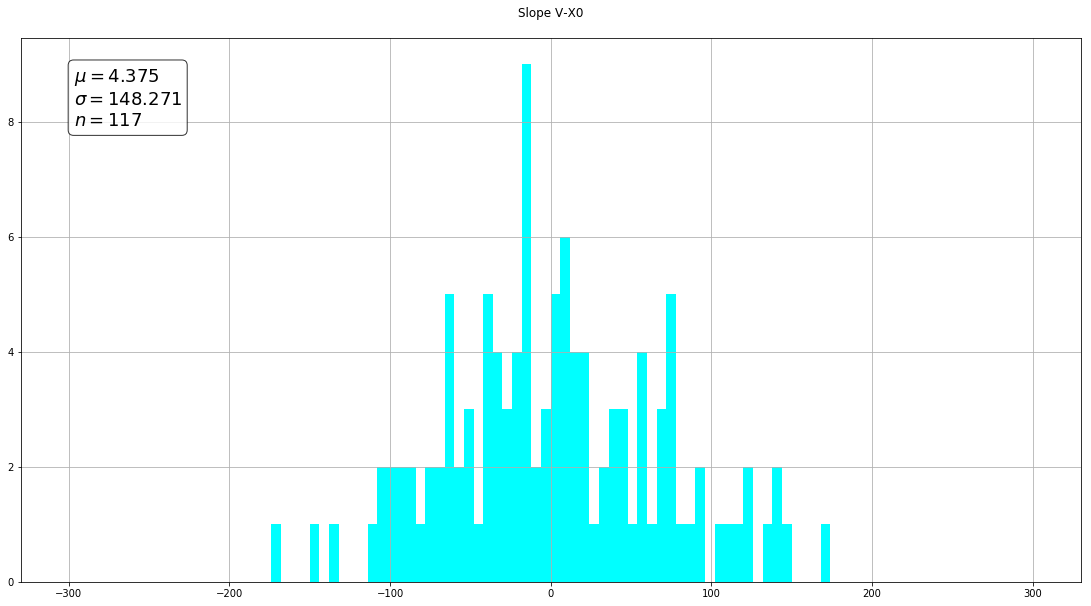

In [11]:
X_plot = []
Y_plot = []

zInf = 1 / (zLays[2] - zLays[0])

event_hits = mc_hits[mc_hits[:,13] < events[1]]
# For each particle of a given event
for particle in event_hits:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
        
        m = float(zLays[0]) / float(X_final[0])
        n = zLays[0] - (m * X_final[0])
        pred = (zLays[3] - n) / m

        Y_plot.append(pred - X_final[3])
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'cyan', -300, 300, 'Slope V-X0', '', '')

In [12]:
X_plot = []
Y_plot = []

event_hits = mc_hits[mc_hits[:,13] < events[1]]

# For each particle of a given event
for particle in event_hits:
    if (len(particle[5]) > 1):
        # Extract only 12 hits, as some of them are really close
        
        X_final = np.zeros(12)
        actual = -1
        for i in range(0, len(particle[5])):
            if (actual != particle[8][i]):
                X_final[actual + 1] = particle[5][i]
                actual = particle[8][i]
                
        if (X_final[3] == 0):
            continue
                
        predicted = (xlayer_model.predict(np.array([X_final[0], 0]).reshape(1,-1)))[0]
        
        Y_plot.append(predicted[1] - X_final[2])
        #print("Range: %f Pred: %f Found: %d" % (search_range,predicted,found_bool))

histogram(Y_plot, 'orange', -600, 600, 'Slope X1-X0', '', '')

NameError: name 'xlayer_model' is not defined